# Evaluating a model

Finally, the model will be evaluated on the test data, ideally the training and validation data will be concatenated for scenarios with sparse data. In this case the decision would have been helpful since in the previous post-tuned model evaluation, the model did not predict well the highest of cloud base height layers. We use the version of the model with the best loss on the independent set of data during training, instead of the model with the best training loss or the final model. There are further limitations around more required epochs, since the model did not converge to a final "best evaluation".

The same evaluation used to diagnose model issues can be used again in this case to point to further direction to be taken by future participants of the machine learning problem, for example, since the task itself deals only in samples without coordinate information, you might point to the coordinate mapped visualization of this evaluation which looks "noisy" to suggest that improvements may be found in making use of coordinate information, by passing over the set of outputs collated into batches at the same timestep or embedding the coordinate information into the input.

### Environment

This notebook is intended to be run in the py-lightning-cbh conda environment defined in requirements_torch.yml

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt

import pandas
import mlflow

import numpy as np
import torch
import zarr
from sklearn.metrics import confusion_matrix

import cbh_data_definitions
import cbh_torch_lstm  # defined in directory (model definition)
import cbh_torch_MLP

import glob

## Define and initialize the evaluation data

In [2]:
root_data_directory = pathlib.Path(os.environ["DATADIR"]) / "cbh_data"
test_data_path = (
    root_data_directory / "analysis_ready" / "test.zarr"
)  # must change with available test data

In [3]:
print(test_data_path)

/data/users/hsouth/cbh_data/analysis_ready/test.zarr


In [4]:
test_input, test_labels, test_cloud_volume = cbh_data_definitions.load_data_from_zarr(
    test_data_path
)
print(test_labels.chunksize[0])
print(len(test_labels))

Loaded zarr, file information:
 Name              : /
Type              : zarr.hierarchy.Group
Read-only         : False
Synchronizer type : zarr.sync.ThreadSynchronizer
Store type        : zarr.storage.DirectoryStore
No. members       : 3
No. arrays        : 3
No. groups        : 0
Arrays            : cloud_base_label_y.zarr, cloud_volume_fraction_y.zarr,
                  : humidity_temp_pressure_x.zarr
 

102400
614400


In [5]:
collate_fn = cbh_data_definitions.dataloader_collate_with_dask
batch_size = int(test_labels.chunksize[0] / 16)
workers_on_system = 0
CPU_COUNT = 4
data_loader_hparam_dict = {
    "batch_size": batch_size,
    "num_workers": workers_on_system,
    "pin_memory": False,
    "collate_fn": collate_fn,
}
test_dataset = cbh_data_definitions.CBH_Dataset_Load_One_Chunk(
    test_input, test_labels, threads=CPU_COUNT
)

In [6]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, **data_loader_hparam_dict)

## Recall a trained model, for this step a particular mlflow experiment is chosen from mlflow_artifacts to evaluate (defined in the cell below)

In [7]:
# init mlflow connection
mlflow_server_address = "10.152.49.117"
mlflow_server_port = 5001
mlflow_server_uri = f"http://{mlflow_server_address}:{mlflow_server_port:d}"
mlflow_client = mlflow.tracking.MlflowClient(tracking_uri=mlflow_server_uri)
mlflow.set_tracking_uri(mlflow_server_uri)

In [8]:
TAKE_ONLY_INTENDED_EXPERIMENTS = False
mlflow_cbh_single_model_training_experiment_id = 3 
all_experiments = [exp.experiment_id for exp in mlflow.search_experiments()]
sort_q = ["metrics.val_loss_mean ASC"] # top of array is best value for given metric when lower is better
if TAKE_ONLY_INTENDED_EXPERIMENTS:
    all_experiments = [f'{mlflow_cbh_single_model_training_experiment_id}']

runs_df = mlflow.search_runs(experiment_ids=all_experiments, order_by=sort_q)

In [9]:
best_artifact = runs_df['artifact_uri'].iloc[0]
model_run_hash = best_artifact.split('/')[-2]
paths = glob.glob(str(best_artifact) + '/*chkpt*')
best_path = paths[0]

In [10]:
TEST_DIR = True

if TEST_DIR:
    model_run_hash = "6fe61152e8374f348cf9ce75e7a4b17e"
    best_path = "./mlruns/3/6fe61152e8374f348cf9ce75e7a4b17e/artifacts/2022-12-08 00:49:17.641711best_model_checkpoint-step_425013.pt"

In [11]:
chkpt = torch.load(best_path)
print(chkpt.keys())

dict_keys(['val loss', 'global_step', 'model_state_dict', 'checkpoint'])


In [12]:
ckpt_instead_of_model_weights = False
chkpt_object_instead_of_pt = False

if ckpt_instead_of_model_weights:
    model = cbh_torch_lstm.CloudBaseLSTM.load_from_checkpoint(checkpoint_path)
else:
    from tempfile import TemporaryDirectory

    with TemporaryDirectory() as tmpdirname:
        tempfile = tmpdirname + "/ckhpt"
        if chkpt_object_instead_of_pt:
            torch.save(chkpt, tempfile)
        else:
            torch.save(chkpt["checkpoint"], tempfile)
            
        model = cbh_torch_lstm.CloudBaseLSTM.load_from_checkpoint(tempfile)
        # model = cbh_torch_MLP.CloudBaseMLP.load_from_checkpoint(tempfile)
model.eval()

Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v1.9.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../../../../../../../../var/tmp/tmp4xicaq_q/ckhpt`


CloudBaseLSTM(
  (LSTM_upward): LSTM(23, 100, num_layers=2, batch_first=True, bidirectional=True)
  (height_embedding): Embedding(70, 20)
  (loss_fn_base): CrossEntropyLoss()
  (scale_input_layer): Conv1d(23, 100, kernel_size=(1,), stride=(1,))
  (cap_layer): Linear(in_features=7000, out_features=70, bias=True)
)

## Get model predictions for Eval

loop through all of the test data, collecting the targets and the model predictions.

In [13]:
MLP = False
LSTM = True

In [14]:
%%time
all_preds = np.empty(0)
all_targs = np.empty(0)
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    # x = torch.flatten(x, start_dim=1)
    with torch.no_grad():
        batch_preds = model(x)  # self call = forward
    class_prediction = np.argmax(batch_preds.detach().numpy(), axis=1)
    all_preds = np.concatenate(
        (all_preds, class_prediction), axis=0
    )  # get second value only (since model doesn't support the other return per how it is currently defined)

print("Length of prediction output:", all_preds.shape)

print("Prediction output matches target output:", all_targs.shape == all_preds.shape)

/net/home/h02/hsouth/github_committing/data_science_cop/challenges/2021_cloud_base_height/cbh_torch_lstm.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  height = torch.tensor(torch.arange(0,70)).repeat((len(x),1)).reshape(len(x),70,1)


Length of prediction output: (614400,)
Prediction output matches target output: True
CPU times: user 1h 24min 26s, sys: 14min 18s, total: 1h 38min 45s
Wall time: 16min 15s


Here a small subset of predictions and targets are given to give the reader an idea of the kind of outputs that come about for the task, then the outputs and targets are binned for a better idea of how the model operates. Due to the class imbalance of our task, it is likely that the model will overpredict the majority classes (0 and 69).

In [15]:
print("Show of some predictions :", all_preds[0:20])
print("Show of some targets, same samples:", all_targs[0:20])
print(
    "Model predictions binned: (Class labels), (Counts):",
    np.unique(all_preds, return_counts=True),
)
print(
    "Target labels binned: (Class labels), (Counts):",
    np.unique(all_targs, return_counts=True),
)
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))

Show of some predictions : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Show of some targets, same samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Model predictions binned: (Class labels), (Counts): (array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 69.]), array([139958,   5574,   7076,  14006,  14296,  14728,  15412,  21100,
        18556,  19240,  21192,  18838,  15644,  17424,   8470,   7062,
         5896,   3772,   3954,   3718,   3412,   3466,   3196,   4420,
         8440,   9296,   3810,   5292,   3922,   4234,   4182,   4536,
         4518,   4430,   4310,   4074,   4358,   5006,   5112,   6440,
         5710,   5244,   3814,   2380,   1292,    178,      8, 123404]))
Target labels binned: (Class labels), (Counts): (array([ 0.,  

## Evaluate model returns

Next, more bespoke evaluation is performed using the metric of SEDI and SEDS for each height layer in the sample as well as more classical metrics: Accuracy, Mean Error, Mean Absolute Error, Root Mean Squared Error

In [16]:
import typing
def new_cbh_eval(preds: typing.Iterable, targs: typing.Iterable, test_before_layer=53):

    batch_length = len(targs)
    cloud_height_expanded_array = np.column_stack(
        np.arange(test_before_layer)
    ).T.repeat(batch_length, 1)
    p = targs <= cloud_height_expanded_array
    q = preds <= cloud_height_expanded_array

    a = p & q
    b = np.logical_not(p) & q
    c = p & np.logical_not(q)
    d = np.logical_not(a | b | c)
    adjust = np.logical_not(a.any(1) & b.any(1))

    l = lambda x: x.sum(1)
    return list(
        zip(
            (np.where(adjust, l(a) + 1, l(a))),
            (np.where(adjust, l(b) + 1, l(b))),
            l(c),
            l(d),
        )
    )

In [17]:
abcd_list = new_cbh_eval(all_preds, all_targs)  # save the eval result

In [18]:
def calc_sedi_numpy(abcd_list):

    sed_arr = np.array(abcd_list)
    n = np.sum(sed_arr, axis=1)
    a = sed_arr[:, 0]
    b = sed_arr[:, 1]
    c = sed_arr[:, 2]
    d = sed_arr[:, 3]
    ar = ((a + b) * (a + c)) / n
    seds = np.log(ar / a) / np.log(a / n)

    h = a / (a + c)
    f = b / (b + d)
    top = np.log((f * (1.0 - h)) / (h * (1.0 - f)))
    bottom = np.log(f * h * (1.0 - f) * (1.0 - h))
    sedi = top / bottom

    return sedi, seds

# perform the same equiv. test but for sedi calculation from previous function output
sedi_list_new, seds_list_new = calc_sedi_numpy(abcd_list)

In [19]:
sedi_score = np.mean(sedi_list_new)
seds_score = np.mean(seds_list_new)

In [20]:
prediction_difference = all_preds - all_targs
print("Accuracy:", np.count_nonzero(all_preds == all_targs) / len(all_preds))
print("Mean Error:", np.mean(prediction_difference))
print("Mean Absolute Error:", np.mean(np.abs(prediction_difference)))
print("Root Mean Squared Error:", np.sqrt(np.mean((prediction_difference) ** 2.0)))
print("SEDI:", sedi_score)
print("SEDS:", seds_score)

Accuracy: 0.7544954427083334
Mean Error: -0.22597330729166668
Mean Absolute Error: 2.7255631510416665
Root Mean Squared Error: 10.540533896236392
SEDI: 0.9682146323537946
SEDS: 0.8498299729275676


## Present Evaluation Plots

Accuracy and Error are common metrics for evaluating model performances across all domains, however in classification problems, a confusion matrix is also provided to give a better idea of the class imblances of both the data and the model imbalance as a visual extension to the class binnings above.

First confusion can be simplified to correct, higher, or lower. Then more detail can be added by visualizing the bins for every class in predictions vs targets

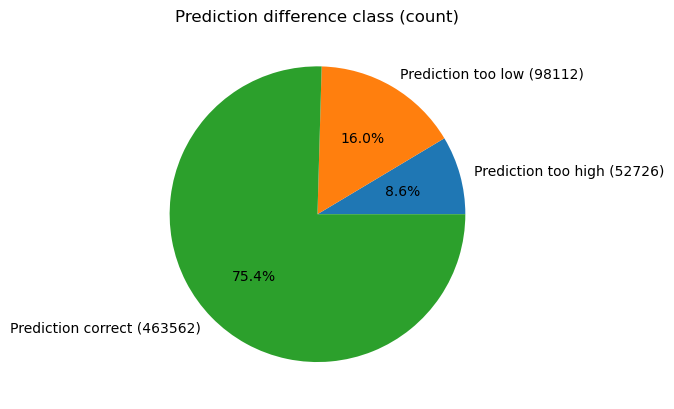

In [21]:
prediction_higher_than_target = np.count_nonzero(all_preds > all_targs)
prediction_lower_than_target = np.count_nonzero(all_preds < all_targs)
prediction_equal_to_target = np.count_nonzero(all_preds == all_targs)
labels = [
    f"Prediction too high ({prediction_higher_than_target})",
    f"Prediction too low ({prediction_lower_than_target})",
    f"Prediction correct ({prediction_equal_to_target})",
]

plt.pie(
    [
        prediction_higher_than_target,
        prediction_lower_than_target,
        prediction_equal_to_target,
    ],
    labels=labels,
    autopct="%1.1f%%",
)
plt.title("Prediction difference class (count)")
plt.show()

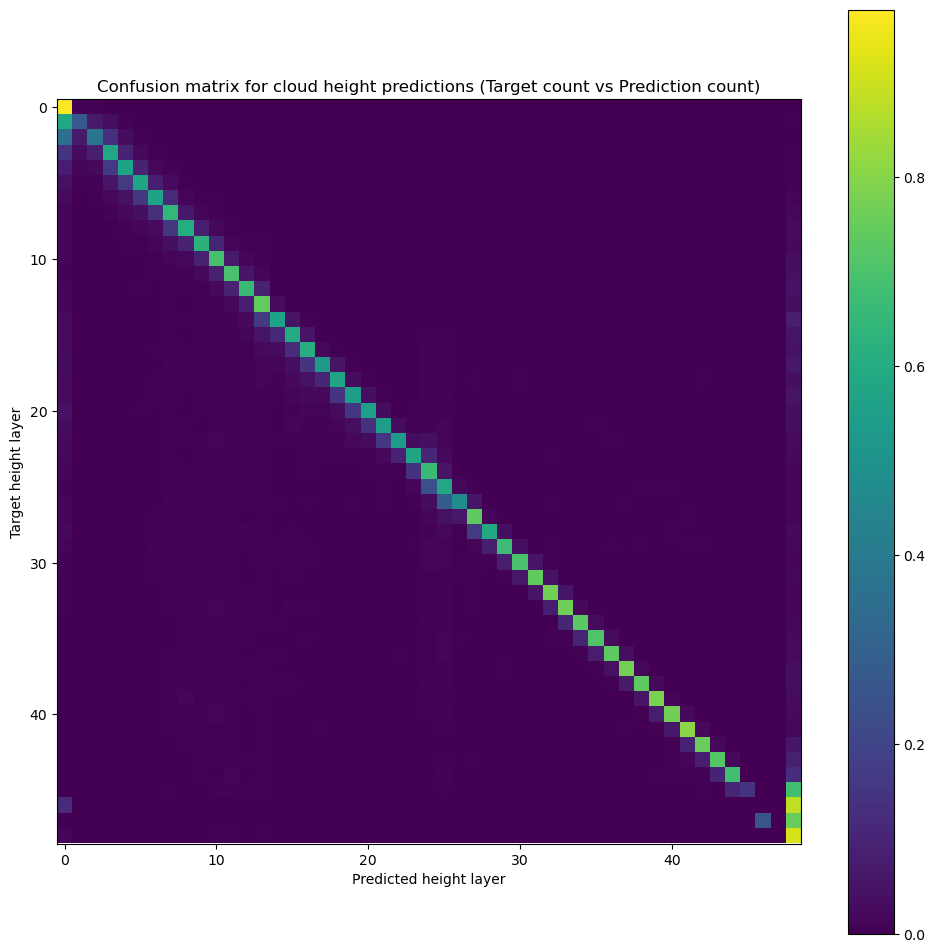


Model predictions binned: (Class label, Count): ((0.0, 139958), (1.0, 5574), (2.0, 7076), (3.0, 14006), (4.0, 14296), (5.0, 14728), (6.0, 15412), (7.0, 21100), (8.0, 18556), (9.0, 19240), (10.0, 21192), (11.0, 18838), (12.0, 15644), (13.0, 17424), (14.0, 8470), (15.0, 7062), (16.0, 5896), (17.0, 3772), (18.0, 3954), (19.0, 3718), (20.0, 3412), (21.0, 3466), (22.0, 3196), (23.0, 4420), (24.0, 8440), (25.0, 9296), (26.0, 3810), (27.0, 5292), (28.0, 3922), (29.0, 4234), (30.0, 4182), (31.0, 4536), (32.0, 4518), (33.0, 4430), (34.0, 4310), (35.0, 4074), (36.0, 4358), (37.0, 5006), (38.0, 5112), (39.0, 6440), (40.0, 5710), (41.0, 5244), (42.0, 3814), (43.0, 2380), (44.0, 1292), (45.0, 178), (46.0, 8), (69.0, 123404)) 

Target labels binned: (Class label, Count): ((0.0, 122834), (1.0, 10292), (2.0, 10808), (3.0, 12698), (4.0, 14760), (5.0, 14746), (6.0, 16566), (7.0, 19216), (8.0, 21306), (9.0, 21208), (10.0, 20580), (11.0, 18622), (12.0, 17136), (13.0, 15252), (14.0, 10586), (15.0, 7564), 

In [22]:
# sedi like a,b,d,c mean confusion matrix

plt.figure(figsize=(12, 12))

confm = confusion_matrix(all_targs, all_preds, normalize="true")
plt.imshow(confm, cmap=plt.cm.viridis, interpolation="nearest")
plt.colorbar()
plt.title(
    "Confusion matrix for cloud height predictions (Target count vs Prediction count)"
)
plt.ylabel("Target height layer")
plt.xlabel("Predicted height layer")
plt.show()

labels, counts = np.unique(all_preds, return_counts=True)
bins_pred = tuple(zip(list(labels), list(counts)))
labels, counts = np.unique(all_targs, return_counts=True)
bins_targ = tuple(zip(list(labels), list(counts)))
print("\nModel predictions binned: (Class label, Count):", bins_pred, "\n")
print("Target labels binned: (Class label, Count):", bins_targ)

In [23]:
print(confm.shape)
print(confm[:, 46])
print(confm[47])

(49, 49)
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.50000000e-01
 4.91859722e-05]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.25 0.   0.75

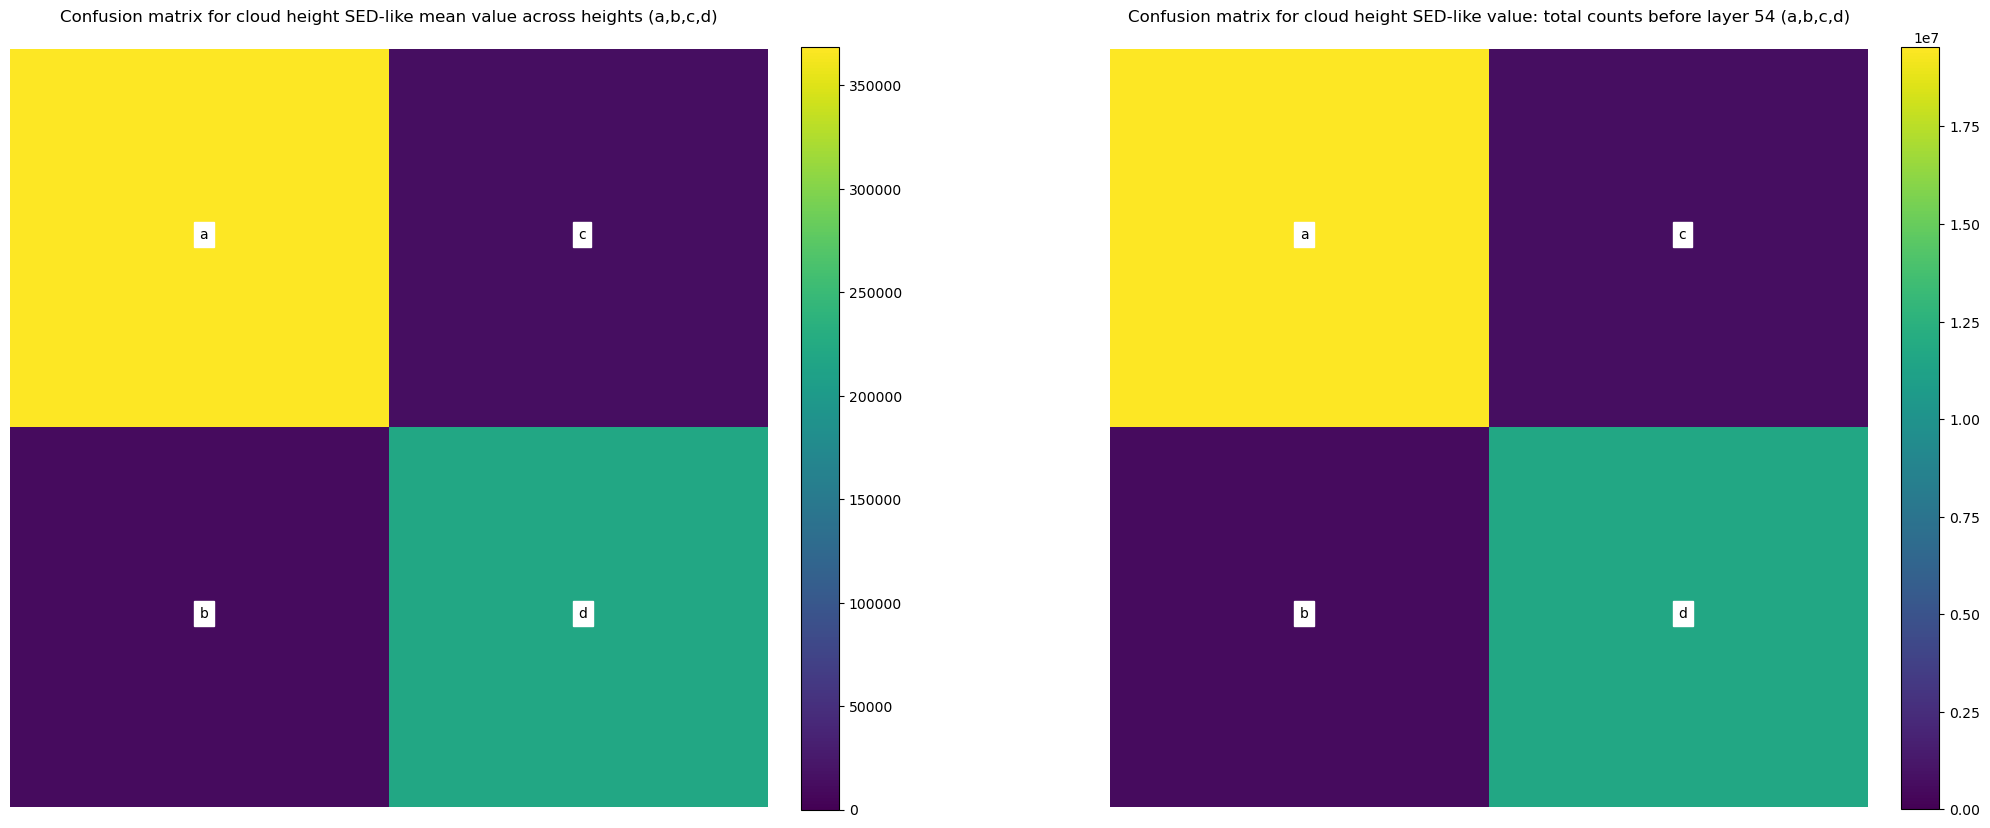

In [24]:
sed_like_conf_matrix = np.reshape(np.mean(np.array(abcd_list).T, axis=1), (2, 2))
labels = ["a", "b", "c", "d"]
fig = plt.figure(figsize=(20, 24))

from matplotlib import colors

divnorm = colors.Normalize(vmin=0.0)
divnorm2 = colors.Normalize(vmin=0.0)

ax1 = fig.add_subplot(121)
im = ax1.imshow(
    sed_like_conf_matrix, cmap=plt.cm.viridis, interpolation="nearest", norm=divnorm
)
for i, lab in enumerate(labels):
    ax1.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im, fraction=0.046, pad=0.04)
ax1.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like mean value across heights (a,b,c,d)",
    pad=20,
)


sed_like_conf_matrix_counts = np.reshape(
    np.sum(np.array(abcd_list[0:54]).T, axis=1), (2, 2)
)
ax2 = fig.add_subplot(122)
im2 = ax2.imshow(
    sed_like_conf_matrix_counts,
    cmap=plt.cm.viridis,
    interpolation="nearest",
    norm=divnorm2,
)
for i, lab in enumerate(labels):
    ax2.text(i // 2, i % 2, lab, backgroundcolor="white")
plt.colorbar(im2, fraction=0.046, pad=0.04)
ax2.axis("off")
plt.title(
    "Confusion matrix for cloud height SED-like value: total counts before layer 54 (a,b,c,d)",
    pad=20,
)
plt.tight_layout(w_pad=15)

plt.show()

## Finally, show the training info for this experiment

In [25]:
print(mlflow_client.search_experiments())

[<Experiment: artifact_location='./mlruns/3', creation_time=1669988962264, experiment_id='3', last_update_time=1669988962264, lifecycle_stage='active', name='cbh-label-model-runs', tags={}>, <Experiment: artifact_location='/data/users/hsouth/mlflow/mlflow_artifacts/2', creation_time=1669304300926, experiment_id='2', last_update_time=1669304300926, lifecycle_stage='active', name='cbh-hparam-tuning', tags={}>, <Experiment: artifact_location='/data/users/hsouth/mlflow/mlflow_artifacts/1', creation_time=1669294833937, experiment_id='1', last_update_time=1669294833937, lifecycle_stage='active', name='test-setup-for-model-runs', tags={}>, <Experiment: artifact_location='/data/users/hsouth/mlflow/mlflow_artifacts/0', creation_time=1669286866110, experiment_id='0', last_update_time=1669286866110, lifecycle_stage='active', name='Default', tags={}>]


In [26]:
experiment_id = 3
runs = mlflow_client.search_runs(experiment_ids=experiment_id)
desired_run = [run for run in runs if run.info.run_id == model_run_hash][0]
print("Run metrics:", desired_run.data.metrics)
print("\nRun Hyperparams:", desired_run.data.params)

Run metrics: {'Val loss': 20.578235626220703, 'val_loss_mean': 20.545438766479492, 'Train loss': 0.0, 'epoch': 0.0, 'Single batch example validation metrics/Correct samples': 100.0, 'Single batch example validation metrics/Total samples tested': 100.0, 'Single batch example validation metrics/Accuracy': 100.0}

Run Hyperparams: {'CPU Count': '8', 'Compute Memory': '64', 'Limited sample number': '-1', 'Random seed': '42', 'Model defined hparams/input_size': '3', 'Model defined hparams/lstm_layers': '2', 'Model defined hparams/lstm_hidden_size': '100', 'Model defined hparams/output_size': '100', 'Model defined hparams/height_dimension': '70', 'Model defined hparams/embed_size': '20', 'Model defined hparams/BILSTM': 'True', 'Model defined hparams/batch_first': 'True', 'Model defined hparams/skip_connection': 'True', 'Model defined hparams/backward_lstm_differing_transitions': 'False', 'Model defined hparams/lr': '0.00146', 'Model defined hparams/norm_method': 'p_l_p_f', 'Model defined hpa

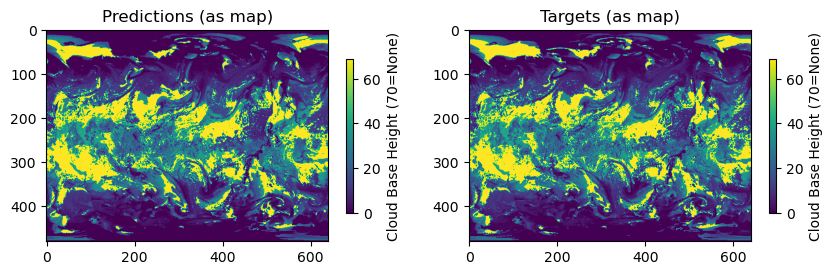

In [27]:
test_preds_single_time = all_preds[:len(all_preds)//2]
test_targs_single_time = all_targs[:len(all_targs)//2]

reshp_preds = test_preds_single_time.reshape(480, 640)
reshp_targ = test_targs_single_time.reshape(480, 640)
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
plt.title("Predictions (as map)")
pos1 = ax1.imshow(reshp_preds)

ax2 = fig.add_subplot(122)
plt.title("Targets (as map)")
pos = ax2.imshow(reshp_targ)


fig.colorbar(pos1, ax=ax1, shrink=0.2, label="Cloud Base Height (70=None)")
fig.colorbar(pos, ax=ax2, shrink=0.2, label="Cloud Base Height (70=None)")
plt.show()

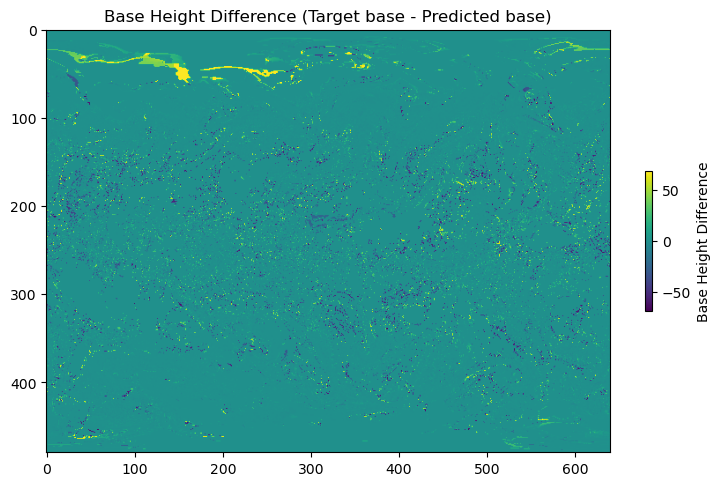

In [28]:
fig = plt.figure(figsize=(20, 20))
ax3 = fig.add_subplot(221)
plt.title("Base Height Difference (Target base - Predicted base)")
diff_reshp = reshp_targ - reshp_preds
pos3 = ax3.imshow(diff_reshp)
fig.colorbar(pos3, ax=ax3, shrink=0.2, label="Base Height Difference")
plt.show()

In [29]:
from scipy.special import softmax

In [30]:
all_pred_distributions = []
for i, sample_batch in enumerate(test_dataloader):
    all_targs = np.concatenate((all_targs, sample_batch[1]), axis=0)
    x = sample_batch[0]
    # x = torch.flatten(x, start_dim=1)
    batch_preds = model(x)  # self call = forward
    all_pred_distributions.append(softmax(batch_preds.detach().numpy(), axis=1))
all_pred_distributions = np.array(all_pred_distributions[0])

/net/home/h02/hsouth/github_committing/data_science_cop/challenges/2021_cloud_base_height/cbh_torch_lstm.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  height = torch.tensor(torch.arange(0,70)).repeat((len(x),1)).reshape(len(x),70,1)


In [31]:
print(all_pred_distributions[0])

[6.1944883e-02 9.2308968e-01 2.3661016e-03 6.9556101e-03 5.0779030e-04
 3.4574834e-06 5.6009762e-06 1.5810577e-06 6.7361964e-07 8.8608056e-07
 4.2937781e-06 6.8111335e-06 1.0430087e-05 1.3004893e-03 3.5048928e-03
 2.6686778e-04 1.2362243e-05 5.5318642e-06 2.3041359e-06 6.8427784e-07
 9.4847491e-07 4.9904673e-07 4.0654828e-07 4.3550713e-07 2.3098289e-07
 2.5630877e-07 2.0713269e-07 2.2794549e-07 2.0864179e-07 1.9622752e-07
 1.3251574e-07 2.4645021e-07 1.8900194e-07 1.9761497e-07 2.7638072e-07
 2.0023442e-07 1.3601256e-07 1.5475825e-07 6.9874517e-08 9.0037801e-08
 2.0968905e-07 7.3400983e-08 1.7683607e-07 2.1164487e-07 1.2847285e-07
 7.6876780e-08 4.1924693e-08 7.0990730e-08 2.6723013e-08 3.9549310e-08
 4.1214683e-08 5.4491949e-09 5.1763000e-11 1.2726792e-12 1.1019206e-12
 1.1462053e-12 1.0728079e-12 1.2553787e-12 1.1693829e-12 1.1768924e-12
 1.1627508e-12 1.2454572e-12 1.0924325e-12 1.1342829e-12 1.0994937e-12
 1.1521365e-12 1.1215257e-12 1.0877707e-12 1.1051241e-12 2.6756982e-06]


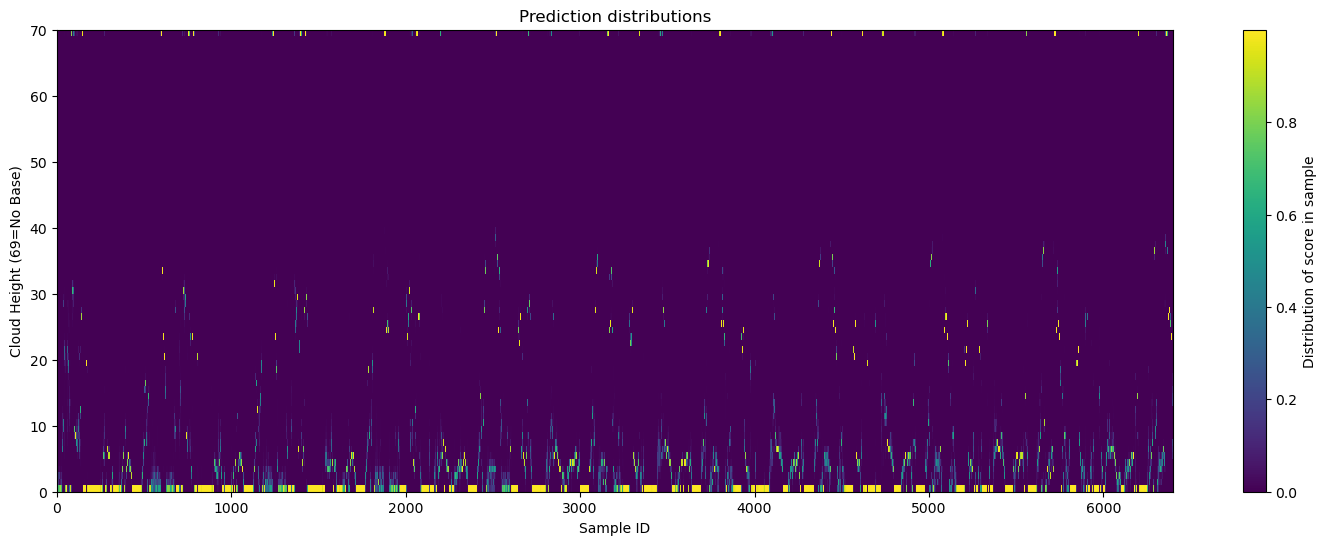

In [34]:
fig, ax = plt.subplots(figsize=(18,6))
plt.title("Prediction distributions")
im = ax.imshow(np.flip(all_pred_distributions.T), extent=[0, len(all_pred_distributions), 0, 70], interpolation="none", aspect='auto')
fig.colorbar(im, cmap='rwb', label="Distribution of score in sample")
plt.xlabel("Sample ID")
plt.ylabel("Cloud Height (69=No Base)")
plt.show()

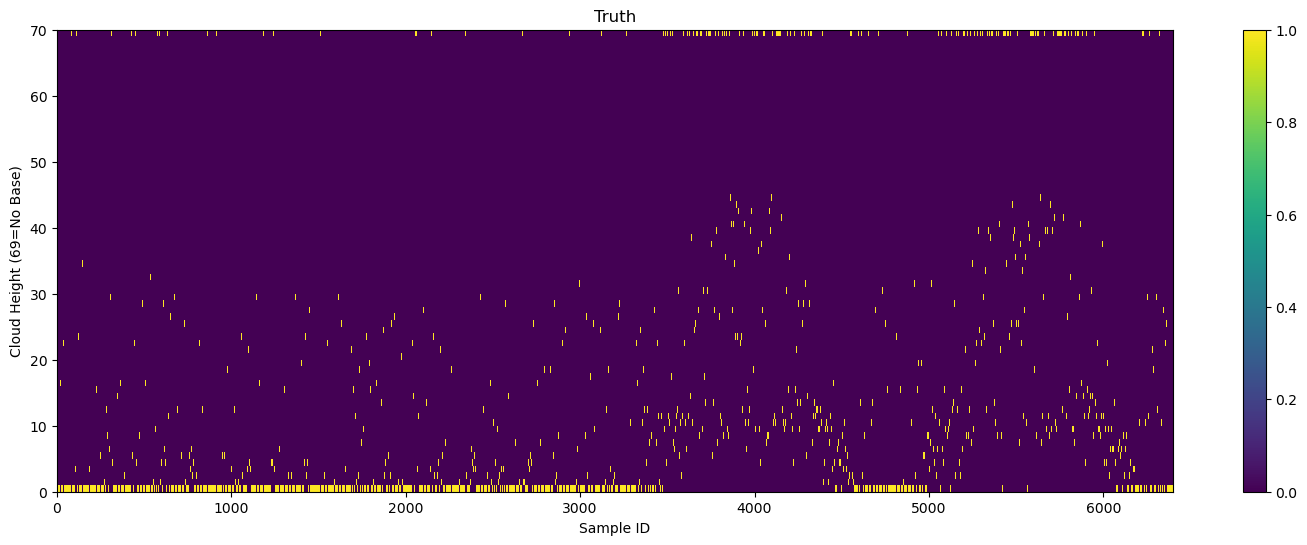

In [35]:
fig, ax = plt.subplots(figsize=(18,6))
nb_classes = 70
targets = all_targs.T.astype(int)
one_hot_targets = np.eye(nb_classes)[targets]
plt.title("Truth")
im = ax.imshow(np.flip(one_hot_targets.T), extent=[0, len(all_pred_distributions), 0, 70], interpolation="none", aspect='auto')
fig.colorbar(im, cmap='rwb')
plt.xlabel("Sample ID")
plt.ylabel("Cloud Height (69=No Base)")
plt.show()